In [2]:
pip install polars
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 1.2 MB/s eta 0:00:0000:0100:010m
Note: you may need to restart the kernel to use updated packages.


In [177]:
pip install pyarrow

Note: you may need to restart the kernel to use updated packages.


In [187]:
!pip install pyarrow

In [25]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [11]:
!curl -o ETTh1.csv https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

/bin/bash: line 1: curl: command not found


In [160]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
import pandas as pd


### Configs

In [267]:
input_size = 30
label_size = 1
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.000001
hidden_size = 64
num_layers = 6
ele = 5
# target_name = 'precipprob'
# date_column = 'datetime'
# file_path = '../assets/weather_24.csv'

target_name = 'precipprob'
date_column = 'datetime'
file_path = '../assets/weather_24.csv'

plot_dir = 'plots'
weight_dir = 'weights'
results =  []

### Data preparation

In [240]:
class TimeSeriesDataLoader:
    def __init__(self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f'Offset will be change from {offset} to {label_size}')
            offset = label_size
        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.train_size = train_size
        self.val_size = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        self.df = pl.read_csv(file_path)
        if date_column is not None: 
            self.df = self.df.drop('datetime')
            self.df = self.df.drop('preciptype')
            self.df = self.df.drop('sealevelpressure')
            self.df = self.df.drop('winddir')
            self.df = self.df.drop('solarradiation')
        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = len(self.df.columns)
            self.out_variable = 1
        else:
            raise ValueError('Features type must be S, M or MS')
        
        self.X_train, self.y_train = self.__create_dataset(0, int(train_size*len(self.df)))
        print(f'{self.X_train.shape=}')
        print(f'{self.y_train.shape=}')
        self.X_val, self.y_val = self.__create_dataset(int(train_size*len(self.df)), int((train_size+val_size)*len(self.df)))
        print(f'{self.X_val.shape=}')
        print(f'{self.y_val.shape=}')
        self.X_test, self.y_test = self.__create_dataset(int((train_size+val_size)*len(self.df)), None)

        self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
        self.X_train = self.normalize_data(self.X_train)  # Normalize training data
        self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
        self.X_val = self.normalize_data(self.X_val)  # Normalize validation data
        self.test_loader = self.__create_dataloader(self.X_test, self.y_test)
        self.X_test = self.normalize_data(self.X_test)  # Normalize test data



    def normalize_data(self, data):
        min_vals = np.min(data, axis=0)
        max_vals = np.max(data, axis=0)
        normalized_data = (data - min_vals) / (max_vals - min_vals)
        return normalized_data

    def __create_dataset(self, start_idx, end_idx):
        if end_idx is None:
            end_idx = len(self.df) - self.label_size - self.offset
        start_idx += self.input_size + self.offset
        features = []
        labels = []

        for idx in range(start_idx, end_idx):
            feature_start_idx = idx - self.input_size - self.offset 
            feature_end_idx = feature_start_idx + self.input_size

            label_start_idx = idx - 1
            label_end_idx = label_start_idx + self.label_size

            if self.features_type == 'S':
                feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            elif self.features_type == 'M':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df[label_start_idx:label_end_idx]
            elif self.features_type == 'MS':
                feature = self.df[feature_start_idx:feature_end_idx]
                label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
            else:
                raise ValueError('Features type must be S, M or MS')
            features.append(feature.to_numpy())
            labels.append(label.to_numpy())
            self.out_features = label.columns
            self.in_features = label.columns
        return np.array(features), np.array(labels)
    def __create_dataloader(self, X, y):
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        dataset = TensorDataset(X_tensor, y_tensor)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


In [241]:
# import pandas as pd
# import numpy as np
# import torch
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import MinMaxScaler

# class TimeSeriesDataLoader:
#     def __init__ (self, file_path, input_size, label_size, offset, train_size, val_size, date_column=None, target_name = None, features_type='M', batch_size=64):
#         if offset < label_size:
#             print(f'Offset will be changed from {offset} to {label_size}')
#             offset = label_size

#         self.input_size = input_size
#         self.label_size = label_size
#         self.offset = offset
#         self.train_size = train_size
#         self.val_size = val_size
#         self.target_name = target_name
#         self.features_type = features_type
#         self.batch_size = batch_size
        
#         # Load the dataset
#         self.df = pd.read_csv(file_path)
        
#         if date_column is not None:
#             drop_columns = ['date']
#             # drop_columns = ['datetime','preciptype']
#             self.df = self.df.drop(columns=drop_columns)
          
#         # Normalize the data
#         self.scaler = MinMaxScaler(feature_range=(0, 1))
#         self.df_normalized = self.normalize_data(self.df)
        
#         # Determine in_variable and out_variable based on features_type
#         if features_type == 'MS':
#             self.in_variable = len(self.df.columns)
#             self.out_variable = 1
#         elif features_type == 'M':
#             self . in_variable = len ( self . df . columns )
#             self . out_variable = len ( self . df . columns )
#         else:
#             raise ValueError(f'features_type {features_type} is not supported')
        
#         self.X_train, self.y_train = self.__create_dataset(0, int(train_size * len(self.df)))
#         print(f'{self.X_train.shape = }')
#         print(f'{self.y_train.shape = }')

#         self.X_val, self.y_val = self.__create_dataset(int(train_size * len(self.df)), int((train_size + val_size) * len(self.df)))
#         print(f'{self.X_val.shape = }')
#         print(f'{self.y_val.shape = }')

#         self.X_test, self.y_test = self.__create_dataset(int((train_size + val_size) * len(self.df)), None)
#         print(f'{self.X_test.shape = }')
#         print(f'{self.y_test.shape = }')
        
#         # Convert to PyTorch DataLoader
#         self.train_loader = self.__create_dataloader(self.X_train, self.y_train)
#         self.val_loader = self.__create_dataloader(self.X_val, self.y_val)
#         self.test_loader = self.__create_dataloader(self.X_test, self.y_test)
    
#     def normalize_data(self, df):
#         # Exclude non-numeric columns if any
#         numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
#         df[numeric_columns] = self.scaler.fit_transform(df[numeric_columns])
#         return df

#     def __create_dataset(self, start_idx, end_idx):
#         if end_idx is None:
#             end_idx = len(self.df_normalized) - self.label_size - self.offset
#         start_idx += self.input_size + self.offset
#         print(start_idx)
#         features = []
#         labels = []
#         for idx in range(start_idx, end_idx):
#             feature_start_idx = idx - self.input_size - self.offset
#             feature_end_idx = feature_start_idx + self.input_size

#             label_start_idx = idx - 1
#             label_end_idx = label_start_idx + self.label_size

#             if self.features_type == 'MS':
#                 feature = self.df_normalized.iloc[feature_start_idx:feature_end_idx].values
#                 label = self.df_normalized[self.target_name].iloc[label_start_idx:label_end_idx].values.reshape(-1, 1)
#             elif self . features_type == 'M':
#                 feature = self . df [ feature_start_idx : feature_end_idx ]
#                 label = self . df [ label_start_idx : label_end_idx ]
#             else:
#                 raise ValueError(f'features_type {self.features_type} is not supported')
#             features.append(feature) 
#             labels.append(label)
#             self.out_features = label.shape[1]
#             self.in_features = feature.shape[1]
            
#         return np.array(features), np.array(labels)
    
#     def __create_dataloader(self, X, y):
#         X_tensor = torch.tensor(X, dtype=torch.float32)
#         y_tensor = torch.tensor(y, dtype=torch.float32)
#         dataset = TensorDataset(X_tensor, y_tensor)
#         return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

In [242]:
features_type = 'MS'
sub_dir = 'multi2uni'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2uni_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

self.X_train.shape=(3653, 30, 17)
self.y_train.shape=(3653, 1, 1)
self.X_val.shape=(495, 30, 17)
self.y_val.shape=(495, 1, 1)


In [243]:
features_type = 'M'
sub_dir = 'multi2multi'
os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)
multi2multi_loader = TimeSeriesDataLoader(file_path, input_size = input_size, label_size= label_size, offset=offset,train_size=train_size, val_size=val_size, target_name=target_name, features_type=features_type, date_column=date_column)

self.X_train.shape=(3653, 30, 17)
self.y_train.shape=(3653, 1, 17)
self.X_val.shape=(495, 30, 17)
self.y_val.shape=(495, 1, 17)


### Training Model Preparation

In [245]:
# class MachineLearningModelManager(ModelManager):
#     def __init__(self, model, xtrain, ytrain, xval, yval):
#         self.model = model
#         self.xtrain = xtrain
#         self.ytrain = ytrain
#         self.xval = xval
#         self.yval = yval
#     def preprocessing(self, x):
#         return x.reshape(x.shape[0], -1)
    
#     def save_model(self, save_path):
#         import pickle
#         with open(save_path, 'wb') as model_file:
#             pickle.dump(self.model, model_file)
#         print(f'Model saved to {save_path}')
#     def train(self, save_dir='.'):
#         self.model.fit(self.preprocessing(self.xtrain), self.preprocessing(self.ytrain),eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
#         save_path = os.path.join(save_dir, f'best={self.model.__class__.__name__}.pkl')
#         self.save_model(save_path=save_path)
#     def predict(self, x):
#         return self.model.predict(self.preprocessing(x))
#     def evaluate(self, x, y):
#         from sklearn.metrics import mean_absolute_error
#         return mean_absolute_error(self.preprocessing(y), self.preprocessing(x))
#     def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
#         yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
#         super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

In [246]:
# class ModelManager:
#     def __init__(self, model, train_loader, val_loader=None, lr=0.0001, patience=100):
#         self.model = model
#         self.train_loader = train_loader
#         self.val_loader = val_loader
#         self.patience = patience
#         self.best_loss = float('inf')
#         self.counter = 0
#         self.criterion = nn.L1Loss()
#         self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#         self.train_loss_per_epoch = []
#         self.val_loss_per_epoch = []

#     def train(self, num_epochs, save_dir='.'):
#         os.makedirs(save_dir, exist_ok=True)
#         save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
#         for epoch in range(num_epochs):
#             start_time = time.time()
#             self.model.train()
#             total_train_loss = 0

#             for inputs, targets in self.train_loader:
#                 #Forward pass
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, targets)
#                 total_train_loss += loss.item()
#                 #Backward pass and optimization
#                 self.optimizer.zero_grad()
#                 loss.backward()
#                 self.optimizer.step()
#             avg_train_loss = total_train_loss / len(self.train_loader)
#             self.train_loss_per_epoch.append(avg_train_loss)

#             #Validation the model

#             val_loss = self.evaluate(loader=self.val_loader) 
#             self.val_loss_per_epoch.append(val_loss)  
#             #Check for early stopping
#             if self.early_stopping(val_loss, save_path):
#                 print(f'Early stopping on epoch {epoch + 1}')
#                 return
#             print(f'Epoch {epoch + 1}/{num_epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, time: {time.time() - start_time:.2f}s')
#         self.save_model(save_path)
    
#     def evaluate(self, loader):
#         self.model.eval()
#         total_loss = 0
        
#         with torch.no_grad():
#             for inputs, targets in loader:
#                 outputs = self.model(inputs)
#                 loss = self.criterion(outputs, targets)
#                 total_loss += loss.item()
        
#         avg_loss = total_loss / len(loader)
#         return avg_loss
    
#     def calculate_accuracy(self, data_loader):
#         self.model.eval()  # Set the model to evaluation mode
#         correct_predictions = 0
#         total_predictions = 0

#         with torch.no_grad():
#             for inputs, targets in data_loader:
#                 outputs = self.predict(inputs)
#                 _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
#                 total_predictions += targets.size(0)
#                 correct_predictions += (predicted == targets).sum().item()

#         return correct_predictions / total_predictions

    
#     def early_stopping(self, val_loss, save_path):
#         if val_loss < self.best_loss:
#             self.best_loss = val_loss
#             self.counter = 0
#             self.save_model(save_path)
#         else:
#             self.counter += 1
#         return self.counter >= self.patience
    
#     def save_model(self, save_path):
#         torch.save(self.model.state_dict(), save_path)
#         print(f'Model saved to {save_path}')
    
#     def load_model(self, load_path):
#         self.model.load_state_dict(torch.load(load_path))
#         print(f'Model loaded from {load_path}')
    
#     def predict(self, input_data):
#         self.model.eval()
#         if isinstance(input_data, DataLoader):
#             predictions = []
#             with torch.no_grad():
#                 for inputs, _ in input_data:
#                     outputs = self.model(inputs)
#                     predictions.append(outputs)
#             predictions = torch.cat(predictions, dim=0)
#         else:
#             with torch.no_grad():
#                 predictions = self.model(input_data).unsqueeze(0)
#         return predictions
    

#     def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
#         if feature_names is None: 
#             feature_names = [f'Feature {i+1}' for i in range(y.shape[2])]
#         if num_elements is not None:
#             y = y[:num_elements]
#             yhat = yhat[:num_elements]
        
#         for feature_index, feature_name in enumerate(feature_names):
#             plt.figure(figsize=(10,5))
#             plt.plot(y[:,:,feature_index].flatten(), label='y', linestyle='-')
#             plt.plot(yhat[:,:,feature_index].flatten(), label='y_hat', linestyle='--')
#             plt.title(f'{feature_name} Forecast')
#             plt.xlabel('Time Steps')
#             plt.ylabel('Values')
#             plt.legend()

#             if save_plots:
#                 os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
#                 save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
#                 plt.savefig(save_path)
#             plt.show()
#             plt.close()
            


# Build Training Model

In [247]:
import torch
import torch.nn as nn
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

class ModelManager:
    def __init__(self, model, train_loader, val_loader=None, lr=0.0001, patience=100):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.train_loss_per_epoch = []
        self.val_loss_per_epoch = []

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')
        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            total_train_loss = 0
            for inputs, targets in self.train_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_train_loss += loss.item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
            avg_train_loss = total_train_loss / len(self.train_loader)
            self.train_loss_per_epoch.append(avg_train_loss)

            val_loss = self.evaluate(loader=self.val_loader) 
            self.val_loss_per_epoch.append(val_loss)  
            if self.early_stopping(val_loss, save_path):
                print(f'Early stopping on epoch {epoch + 1}')
                return
            print(f'Epoch {epoch + 1}/{num_epochs}, train_loss: {avg_train_loss:.4f}, val_loss: {val_loss:.4f}, time: {time.time() - start_time:.2f}s')
        self.save_model(save_path)
    
    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0
        with torch.no_grad():
            for inputs, targets in loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        return avg_loss
    
    def calculate_accuracy(self, data_loader):
        self.model.eval()
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for inputs, targets in data_loader:
                inputs, targets = inputs.to(self.device), targets.to(self.device)
                outputs = self.predict(inputs)
                _, predicted = torch.max(outputs, 1)
                total_predictions += targets.size(0)
                correct_predictions += (predicted == targets).sum().item()
        return correct_predictions / total_predictions

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience
    
    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f'Model saved to {save_path}')
    
    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f'Model loaded from {load_path}')
    
    def predict(self, input_data):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        self.model.eval()
        if isinstance(input_data, DataLoader):
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    inputs = inputs.to(device)
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            with torch.no_grad():
                input_data = input_data.to(device)
                predictions = self.model(input_data).unsqueeze(0)
        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None: 
            feature_names = [f'Feature {i+1}' for i in range(y.shape[2])]
            
        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10,5))
            plt.plot(y[:,:,feature_index].flatten(), label='y', linestyle='-')
            plt.plot(yhat[:,:,feature_index].flatten().cpu().numpy(), label='y_hat', linestyle='--')
            plt.title(f'{feature_name} Forecast')
            plt.xlabel('Time Steps')
            plt.ylabel('Values')
            plt.legend()
            if save_plots:
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f'{feature_name}.png')
                plt.savefig(save_path)
            plt.show()
            plt.close()
            
class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval
    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)
    
    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f'Model saved to {save_path}')
    def train(self, save_dir='.'):
        self.model.fit(self.preprocessing(self.xtrain), self.preprocessing(self.ytrain),eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f'best={self.model.__class__.__name__}.pkl')
        self.save_model(save_path=save_path)
    def predict(self, x):
        return self.model.predict(self.preprocessing(x))
    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        return mean_absolute_error(self.preprocessing(y), self.preprocessing(x))
    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names=feature_names, save_dir=save_dir, save_plots=save_plots, num_elements=num_elements)

In [248]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)
        self.ahead = ahead
        self.output_size=output_size
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)

In [249]:
MLP_multi2uni = MLP(input_size=multi2uni_loader.in_variable*input_size, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size)

MLP_multi2uni_manager = ModelManager(model=MLP_multi2uni, train_loader=multi2uni_loader.train_loader,val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
MLP_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    'MAE': MLP_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
    "Accuracy": MLP_multi2uni_manager.calculate_accuracy(data_loader=multi2multi_loader.test_loader)
})
results[-1]

Model saved to weights/multi2multi/best-MLP.pth
Epoch 1/1000000, train_loss: 64.8517, val_loss: 64.6827, time: 0.09s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 2/1000000, train_loss: 57.3349, val_loss: 58.0417, time: 0.06s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 3/1000000, train_loss: 51.8335, val_loss: 51.0426, time: 0.05s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 4/1000000, train_loss: 45.5604, val_loss: 43.9713, time: 0.04s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 5/1000000, train_loss: 39.6586, val_loss: 37.0366, time: 0.04s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 6/1000000, train_loss: 34.1815, val_loss: 31.1315, time: 0.05s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 7/1000000, train_loss: 31.2573, val_loss: 29.0474, time: 0.05s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 8/1000000, train_loss: 30.4740, val_loss: 28.5697, time: 0.05s
Model saved to weights/multi2multi/best-MLP.pth
Epoch 9/1000000,

{'Name': 'MLP',
 'Type': 'multi2multi',
 'MAE': 15.499702751636505,
 'Accuracy': 0.12156862745098039}

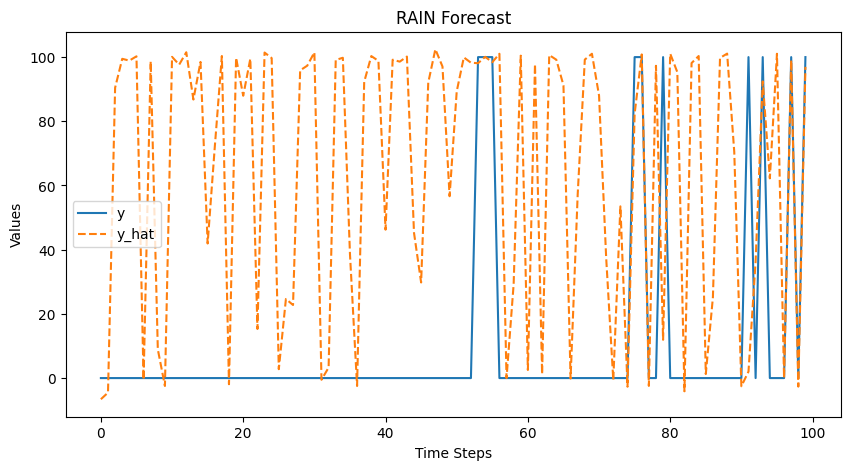

In [251]:
# Generate predictions on the training data
test_predictions = MLP_multi2uni_manager.predict(multi2uni_loader.train_loader)

# Get the true values
y_true = multi2uni_loader.y_train

# Plot the true values against the predictions
MLP_multi2uni_manager.plot(y=y_true, yhat=test_predictions, feature_names=["RAIN"], num_elements=100, save_plots=False)

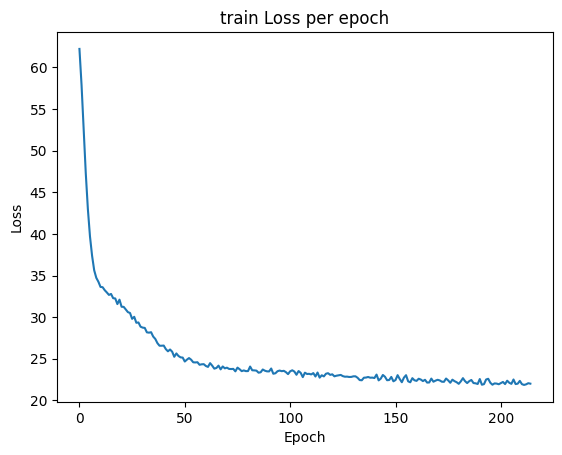

In [229]:
plt.plot(MLP_multi2uni_manager.train_loss_per_epoch)
plt.title('train Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

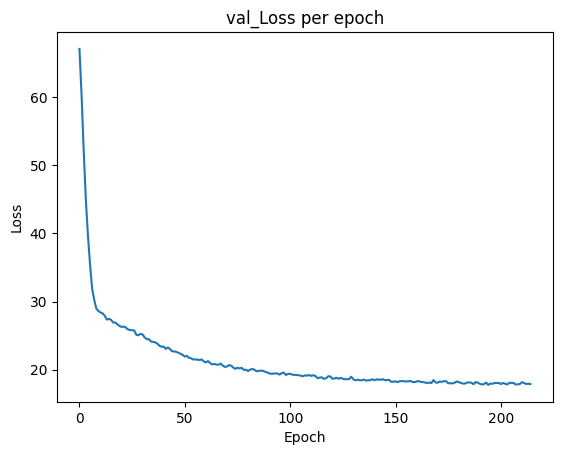

In [230]:
plt.plot(MLP_multi2uni_manager.val_loss_per_epoch)
plt.title('val_Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [231]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device)
        out, _ = self.lstm(x.to(self.device), (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [232]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)

LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)

LSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})      

results[-1]


/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([64, 7, 1])) that is different to the input size (torch.Size([64, 7, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([3, 7, 1])) that is different to the input size (torch.Size([3, 7, 17])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)
/home/blackcait/.miniconda3/envs/pytorch_env/lib/python3.12/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([45, 7, 1])) that is different to the input size (torch.Size([45, 7, 17])). T

Model saved to weights/multi2multi/best-LSTM.pth
Epoch 1/1000000, train_loss: 63.8721, val_loss: 71.9763, time: 0.10s
Epoch 2/1000000, train_loss: 62.9918, val_loss: 72.1589, time: 0.13s
Epoch 3/1000000, train_loss: 63.8617, val_loss: 71.9915, time: 0.10s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 4/1000000, train_loss: 63.4585, val_loss: 71.6890, time: 0.10s
Epoch 5/1000000, train_loss: 63.5321, val_loss: 71.7625, time: 0.09s
Epoch 6/1000000, train_loss: 63.9231, val_loss: 72.2378, time: 0.09s
Epoch 7/1000000, train_loss: 62.9609, val_loss: 72.1599, time: 0.10s
Epoch 8/1000000, train_loss: 64.0642, val_loss: 71.7842, time: 0.10s
Epoch 9/1000000, train_loss: 63.8939, val_loss: 72.1032, time: 0.09s
Epoch 10/1000000, train_loss: 63.3237, val_loss: 71.7335, time: 0.09s
Epoch 11/1000000, train_loss: 63.9418, val_loss: 71.9368, time: 0.09s
Epoch 12/1000000, train_loss: 63.6825, val_loss: 72.2015, time: 0.10s
Epoch 13/1000000, train_loss: 62.8657, val_loss: 71.7652, time: 0.09s
E

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 24.346479415893555}

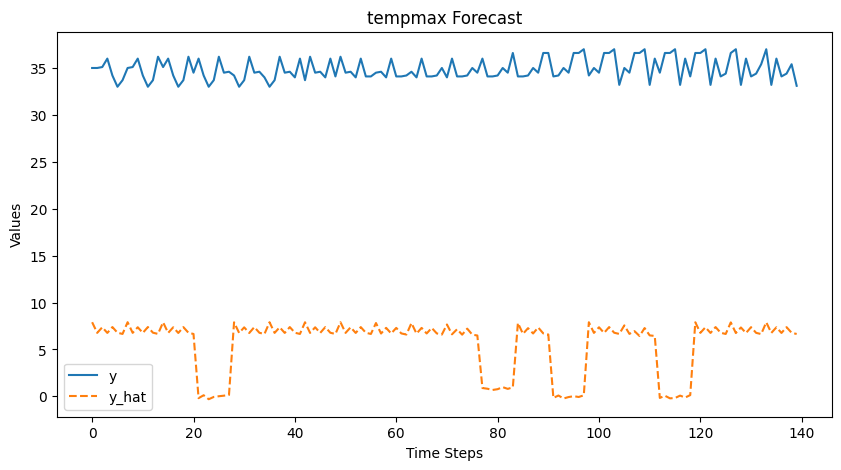

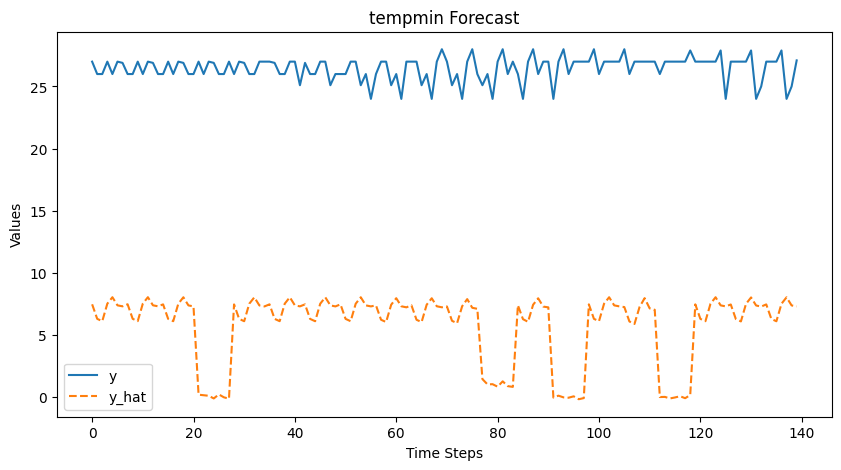

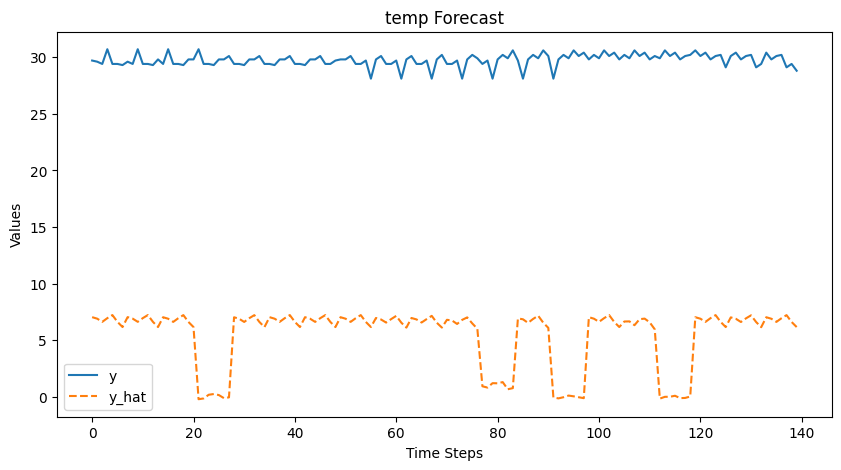

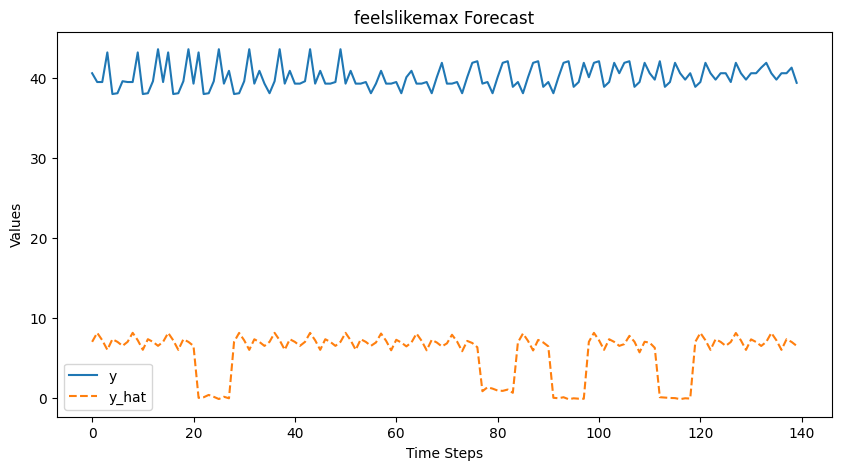

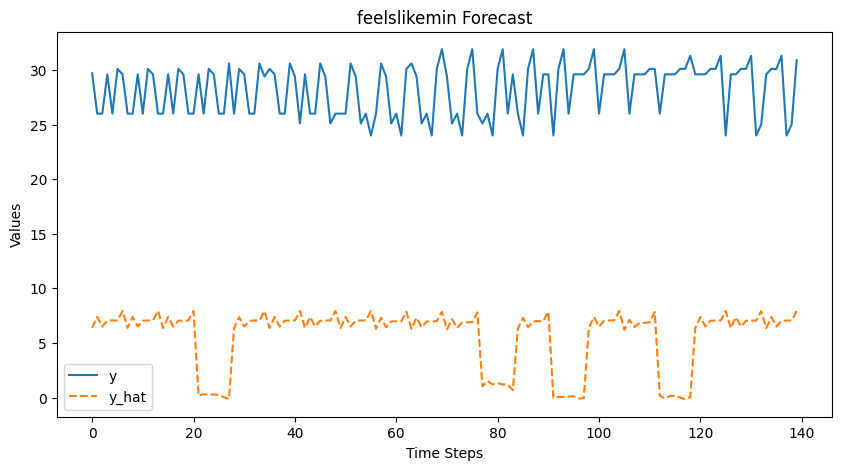

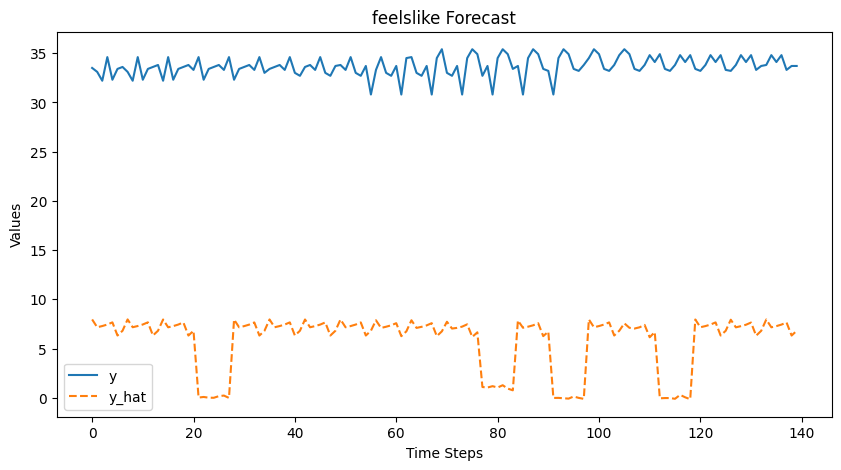

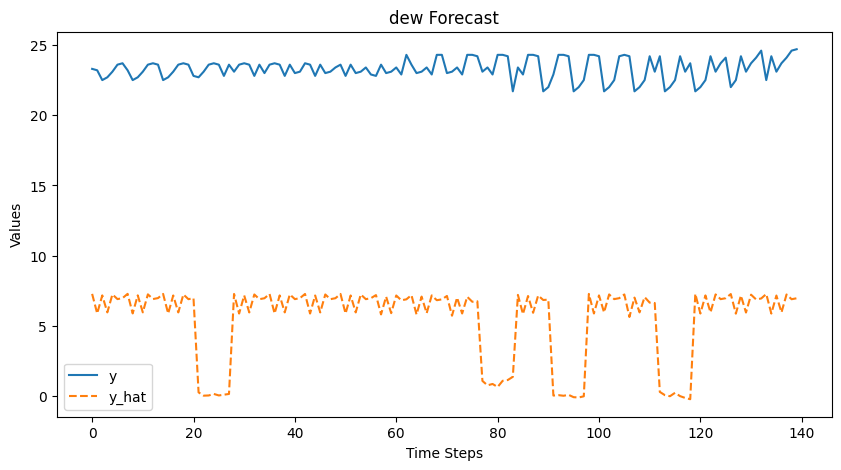

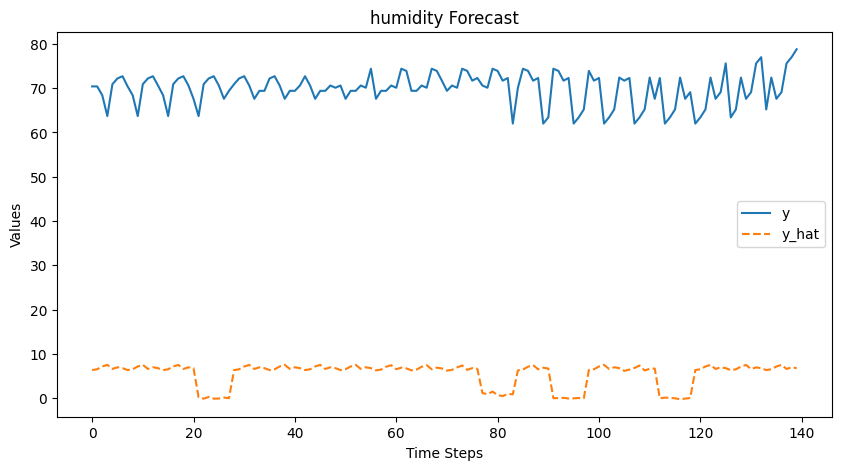

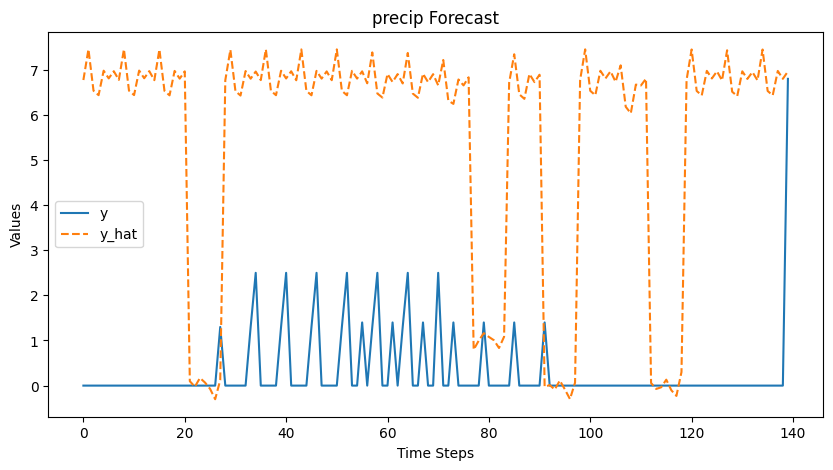

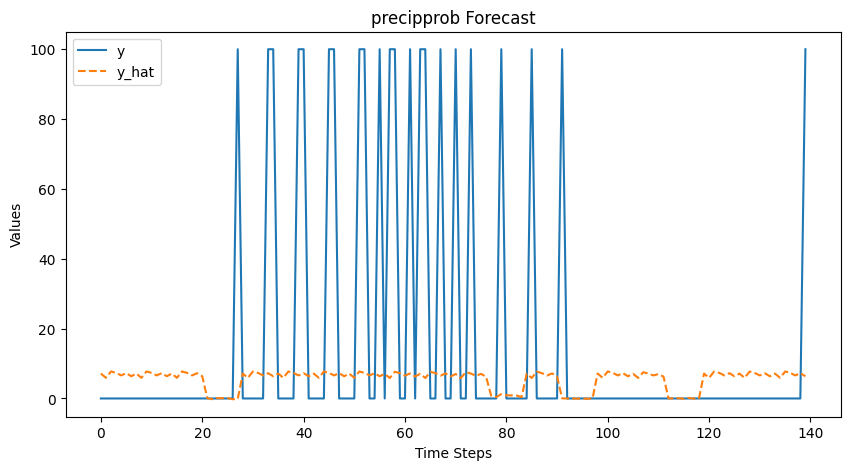

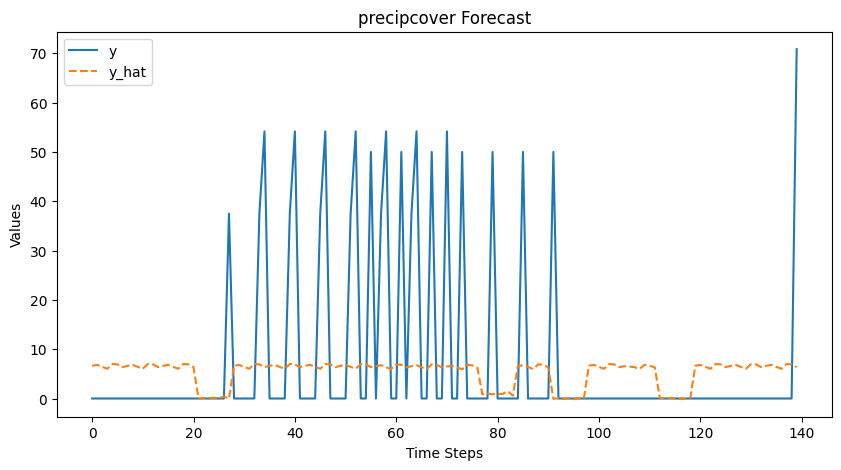

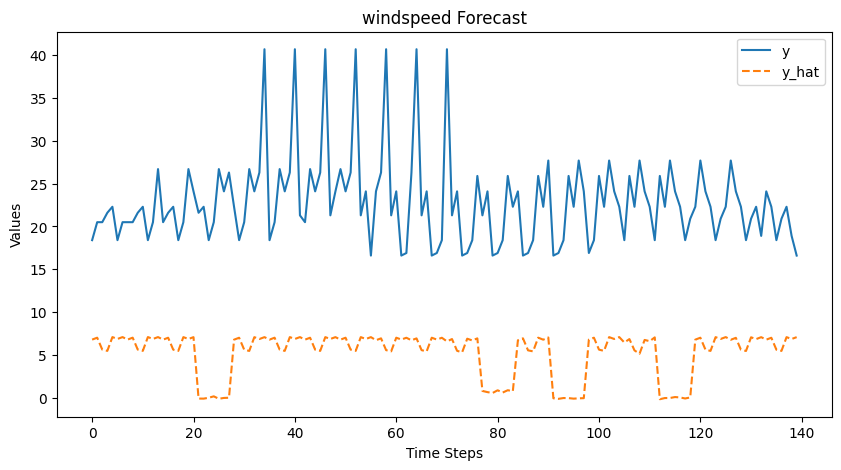

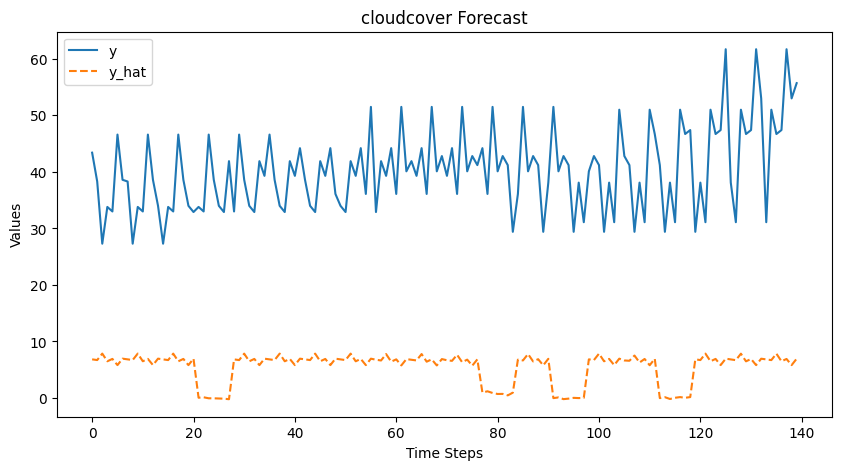

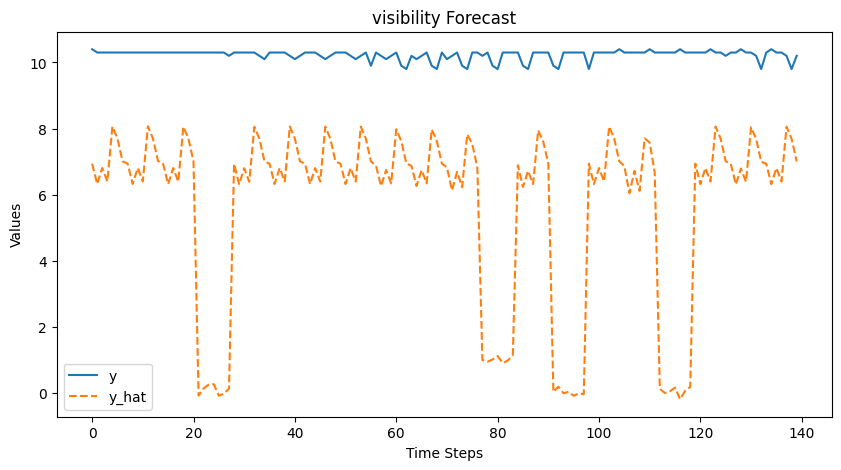

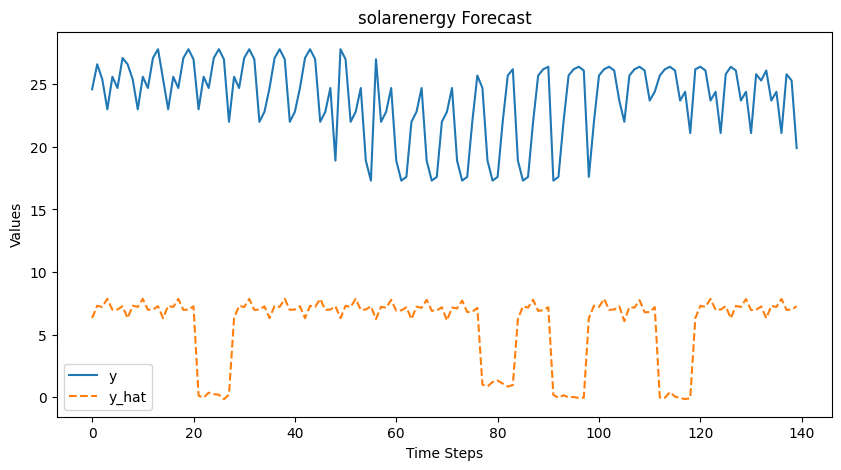

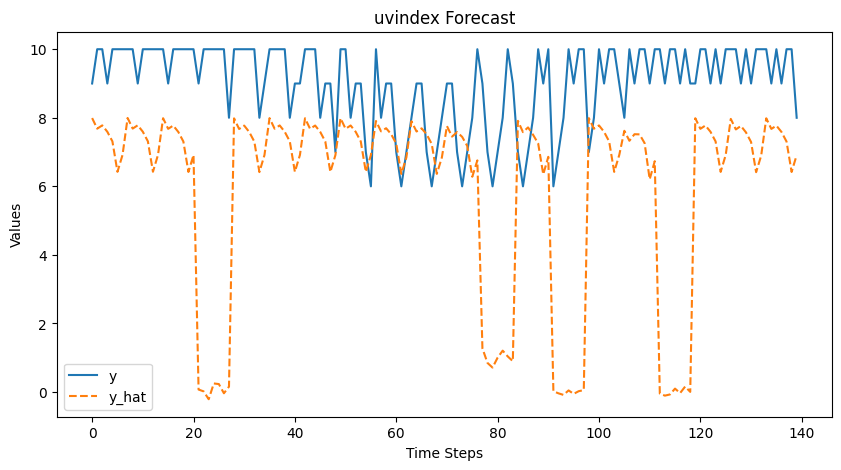

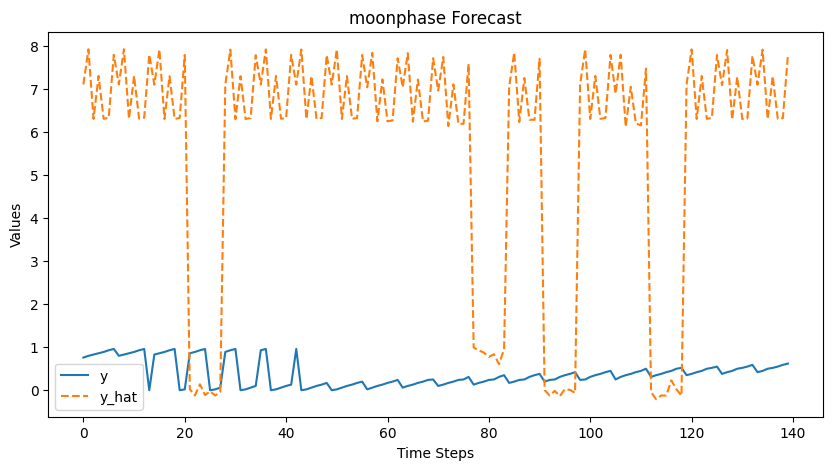

In [233]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.train_loader
mul2mul_data_y = multi2multi_loader.y_train
model_activation = LSTM_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=20, save_plots=False)

In [211]:
yhat.shape

torch.Size([3587, 7, 1])

In [107]:
# Get a batch of test data
test_inputs, test_targets = next(iter(multi2multi_loader.test_loader))
test_predictions = LSTM_multi2multi_manager.predict(test_inputs)
# LSTM_multi2multi_manager.plot(test_inputs, test_targets)

In [112]:
test_predictions.shape


torch.Size([1, 64, 96, 17])

In [109]:
test_targets.shape

torch.Size([64, 96, 17])

In [98]:
test_inputs

tensor([[[3.4800e+01, 2.7000e+01, 2.9900e+01,  ..., 1.9500e+01,
          8.0000e+00, 3.1000e-01],
         [3.4800e+01, 2.7000e+01, 3.0100e+01,  ..., 2.2200e+01,
          9.0000e+00, 3.4000e-01],
         [3.3800e+01, 2.6000e+01, 2.9400e+01,  ..., 1.5700e+01,
          9.0000e+00, 3.7000e-01],
         ...,
         [3.6700e+01, 2.7000e+01, 3.1000e+01,  ..., 2.7800e+01,
          1.0000e+01, 5.7000e-01],
         [3.6000e+01, 2.7900e+01, 3.0700e+01,  ..., 2.2900e+01,
          9.0000e+00, 6.1000e-01],
         [3.4000e+01, 2.6000e+01, 3.0000e+01,  ..., 2.7200e+01,
          1.0000e+01, 6.4000e-01]],

        [[3.3000e+01, 2.5000e+01, 2.7800e+01,  ..., 1.6400e+01,
          7.0000e+00, 1.5000e-01],
         [3.2000e+01, 2.5000e+01, 2.7200e+01,  ..., 1.3500e+01,
          5.0000e+00, 1.8000e-01],
         [3.4000e+01, 2.4100e+01, 2.8700e+01,  ..., 1.7500e+01,
          7.0000e+00, 2.2000e-01],
         ...,
         [3.4000e+01, 2.5000e+01, 2.7400e+01,  ..., 1.9200e+01,
          9.000

In [78]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size, num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-LSTM.pth
Epoch 1/1000000, train_loss: 63.1621, val_loss: 95.1247, time: 0.21s
Epoch 2/1000000, train_loss: 63.2244, val_loss: 95.1717, time: 0.20s
Epoch 3/1000000, train_loss: 63.1874, val_loss: 95.1718, time: 0.30s
Epoch 4/1000000, train_loss: 63.1765, val_loss: 95.1437, time: 0.19s
Epoch 5/1000000, train_loss: 63.2013, val_loss: 95.1786, time: 0.20s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 6/1000000, train_loss: 63.1759, val_loss: 95.0918, time: 0.20s
Epoch 7/1000000, train_loss: 63.1506, val_loss: 95.1225, time: 0.20s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 8/1000000, train_loss: 63.1516, val_loss: 95.0393, time: 0.20s
Epoch 9/1000000, train_loss: 63.1309, val_loss: 95.0544, time: 0.20s
Epoch 10/1000000, train_loss: 63.1344, val_loss: 95.1276, time: 0.21s
Epoch 11/1000000, train_loss: 63.1616, val_loss: 95.1404, time: 0.20s
Model saved to weights/multi2multi/best-LSTM.pth
Epoch 12/1000000, train_loss: 63.1202, val_

{'Name': 'LSTM',
 'Type': 'multi2multi',
 'MAE': 36.04263687133789,
 'Accuracy': 16.361305361305362}

In [92]:
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

{'Name': 'LSTM', 'Type': 'multi2multi', 'MAE': 36.09023829868862}

In [74]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size * ahead)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [79]:
RNN_multi2uni = RNN(input_size = multi2uni_loader.in_variable, hidden_size = hidden_size, output_size = multi2uni_loader.out_variable, ahead = label_size, num_layers=num_layers)
RNN_multi2uni = ModelManager(model=RNN_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
RNN_multi2uni.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2uni.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2uni.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch 1/1000000, train_loss: 63.2555, val_loss: 95.1433, time: 0.12s
Epoch 2/1000000, train_loss: 63.2324, val_loss: 95.4776, time: 0.11s
Epoch 3/1000000, train_loss: 63.2189, val_loss: 95.2150, time: 0.12s
Epoch 4/1000000, train_loss: 63.2141, val_loss: 95.3013, time: 0.12s
Epoch 5/1000000, train_loss: 63.1907, val_loss: 95.1751, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 6/1000000, train_loss: 63.1813, val_loss: 94.8467, time: 0.12s
Epoch 7/1000000, train_loss: 63.1917, val_loss: 95.0604, time: 0.12s
Epoch 8/1000000, train_loss: 63.1813, val_loss: 94.9795, time: 0.12s
Epoch 9/1000000, train_loss: 63.1564, val_loss: 95.0982, time: 0.12s
Epoch 10/1000000, train_loss: 63.1138, val_loss: 94.9423, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 11/1000000, train_loss: 63.1026, val_loss: 94.8319, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 12/1000000, train_loss: 63.1343, val_loss

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 26.633978162493026}

In [75]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size,output_size = multi2multi_loader.out_variable,ahead=label_size,num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,train_loader=multi2multi_loader.train_loader,val_loader=multi2multi_loader.val_loader,lr=learning_rate,patience=patience)
RNN_multi2multi_manager.train(num_epochs=num_epochs,save_dir=os.path.join(weight_dir,sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-RNN.pth
Epoch 1/1000000, train_loss: 28.0154, val_loss: 31.4907, time: 0.21s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 2/1000000, train_loss: 27.9980, val_loss: 31.4725, time: 0.13s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 3/1000000, train_loss: 27.9787, val_loss: 31.4405, time: 0.14s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 4/1000000, train_loss: 27.9658, val_loss: 31.4092, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 5/1000000, train_loss: 27.9376, val_loss: 31.3888, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 6/1000000, train_loss: 27.9106, val_loss: 31.3490, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 7/1000000, train_loss: 27.8725, val_loss: 31.3124, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 8/1000000, train_loss: 27.8392, val_loss: 31.2718, time: 0.12s
Model saved to weights/multi2multi/best-RNN.pth
Epoch 9/1000000,

{'Name': 'RNN', 'Type': 'multi2multi', 'MAE': 4.871362004961286}

In [256]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()  
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [268]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable, hidden_size=hidden_size, output_size=multi2multi_loader.out_variable, ahead=label_size, num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi, train_loader=multi2multi_loader.train_loader, val_loader=multi2multi_loader.val_loader, lr=learning_rate, patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader),
})
results[-1]

Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 1/1000000, train_loss: 28.1149, val_loss: 28.1332, time: 0.31s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 2/1000000, train_loss: 28.0420, val_loss: 28.1087, time: 0.23s
Epoch 3/1000000, train_loss: 28.1407, val_loss: 28.1108, time: 0.22s
Epoch 4/1000000, train_loss: 28.0942, val_loss: 28.1147, time: 0.22s
Model saved to weights/multi2multi/best-BiLSTM.pth
Epoch 5/1000000, train_loss: 28.1466, val_loss: 28.0655, time: 0.22s
Epoch 6/1000000, train_loss: 28.0380, val_loss: 28.0775, time: 0.22s
Epoch 7/1000000, train_loss: 28.0801, val_loss: 28.0926, time: 0.22s
Epoch 8/1000000, train_loss: 28.0787, val_loss: 28.0673, time: 0.22s
Epoch 9/1000000, train_loss: 28.0253, val_loss: 28.0880, time: 0.22s
Epoch 10/1000000, train_loss: 28.0385, val_loss: 28.0901, time: 0.22s
Epoch 11/1000000, train_loss: 28.0706, val_loss: 28.0660, time: 0.22s
Epoch 12/1000000, train_loss: 28.0782, val_loss: 28.0813, time: 0.22s
Epoch 13/1000000

{'Name': 'BiLSTM', 'Type': 'multi2multi', 'MAE': 9.864158749580383}

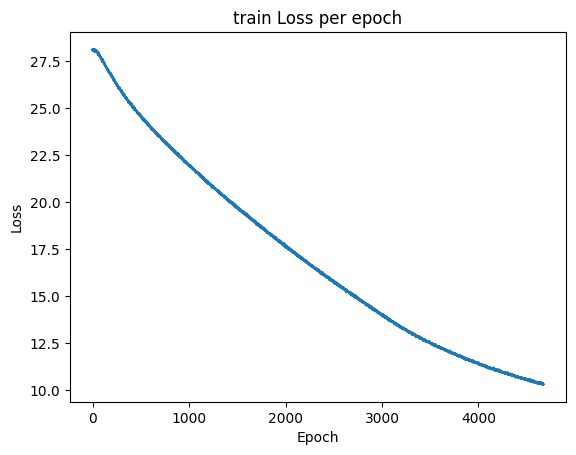

In [269]:
plt.plot(BiLSTM_multi2multi_manager.train_loss_per_epoch)
plt.title('train Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

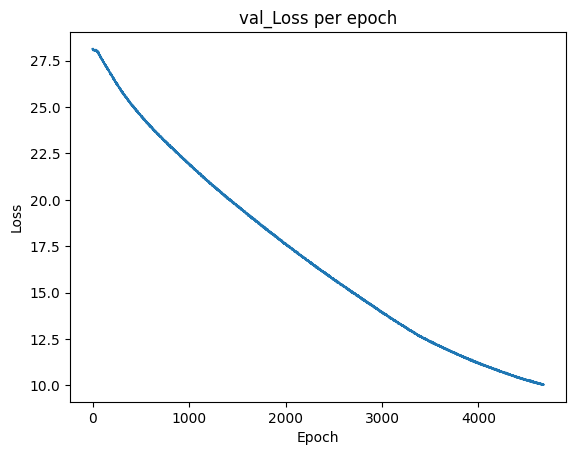

In [270]:
plt.plot(BiLSTM_multi2multi_manager.val_loss_per_epoch)
plt.title('val_Loss per epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

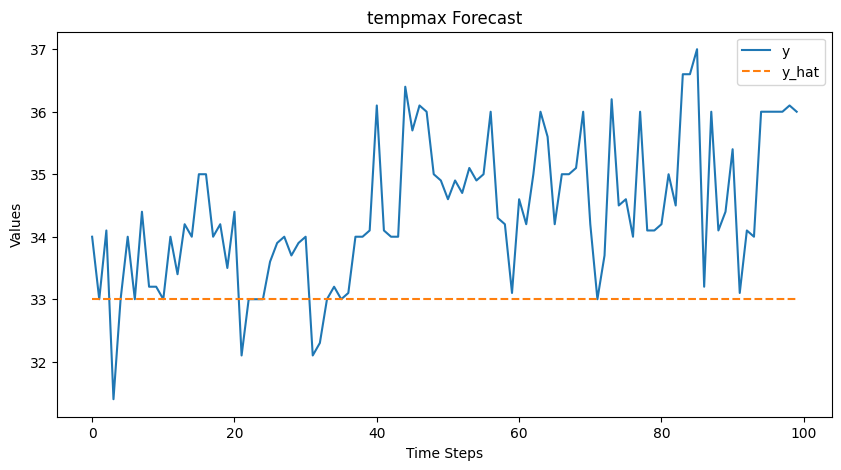

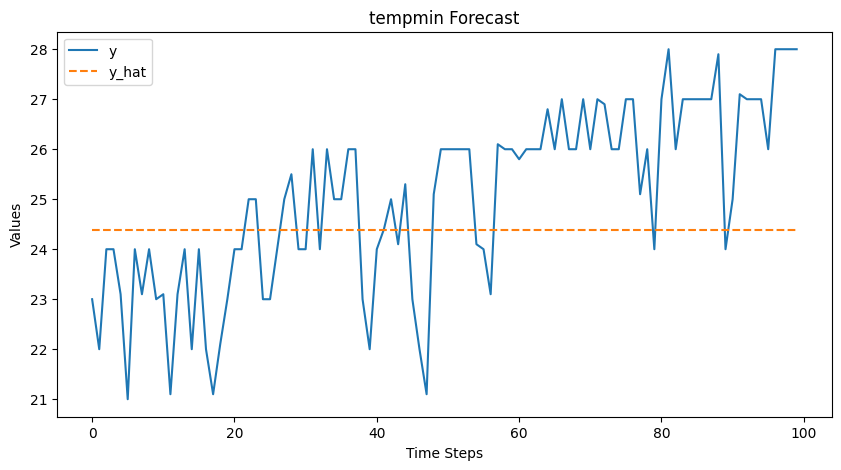

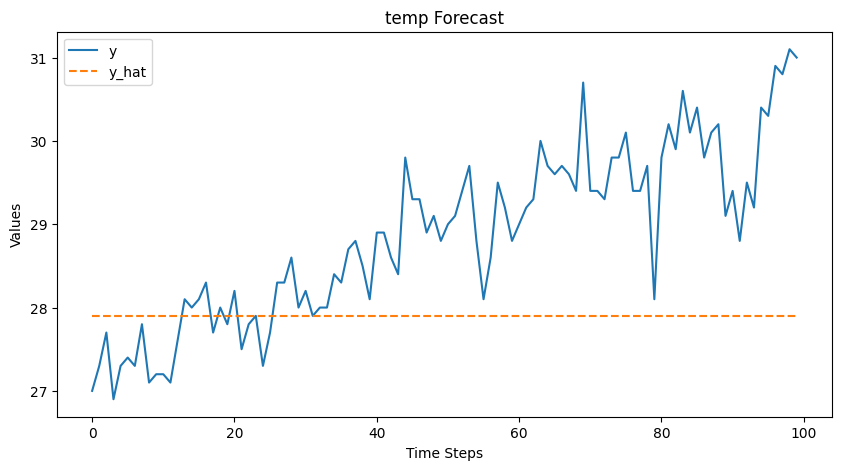

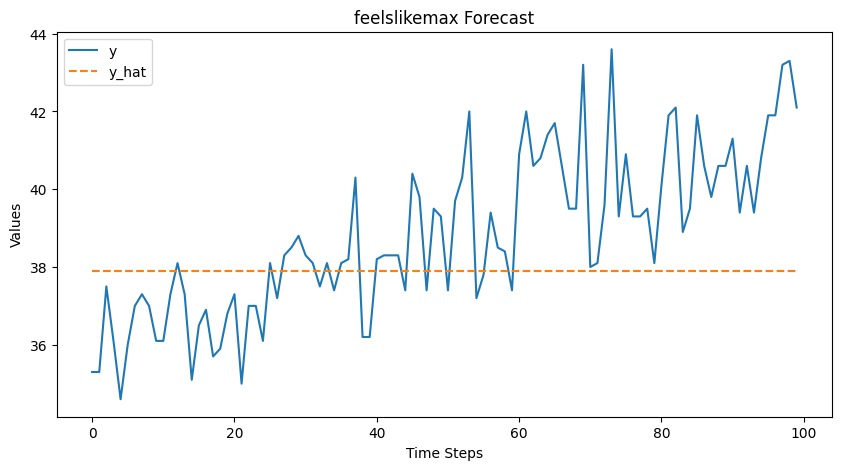

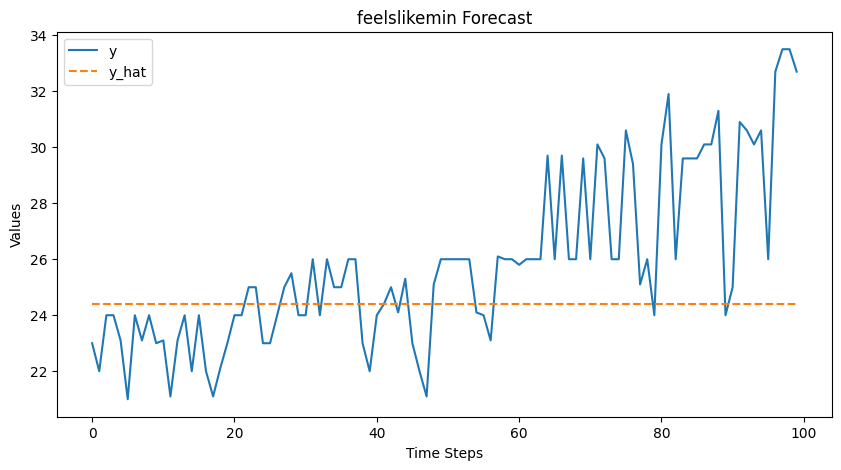

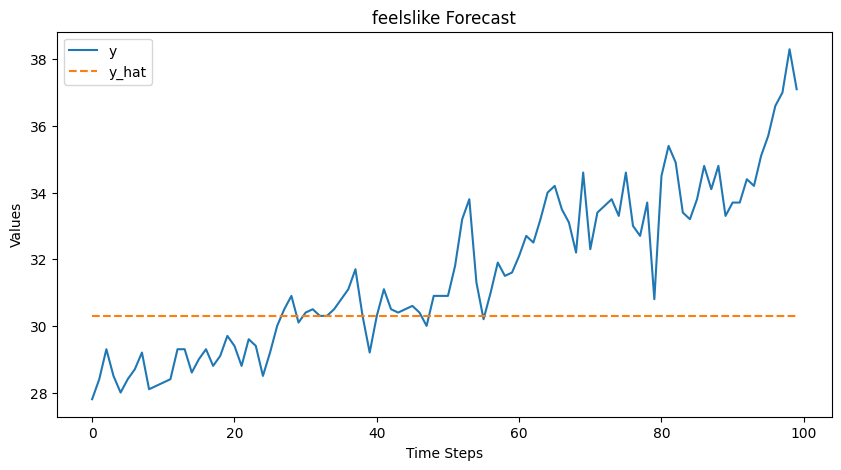

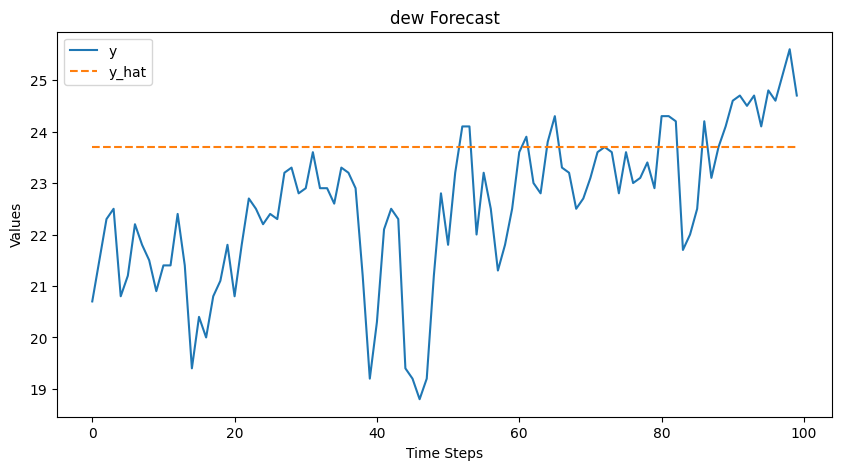

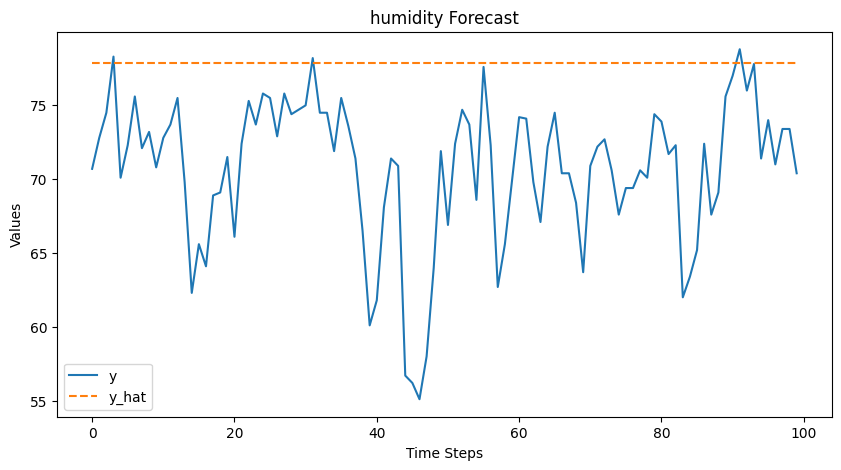

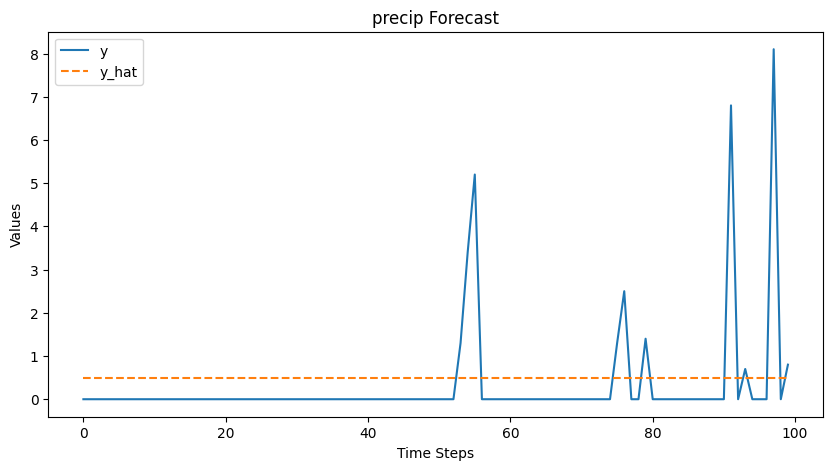

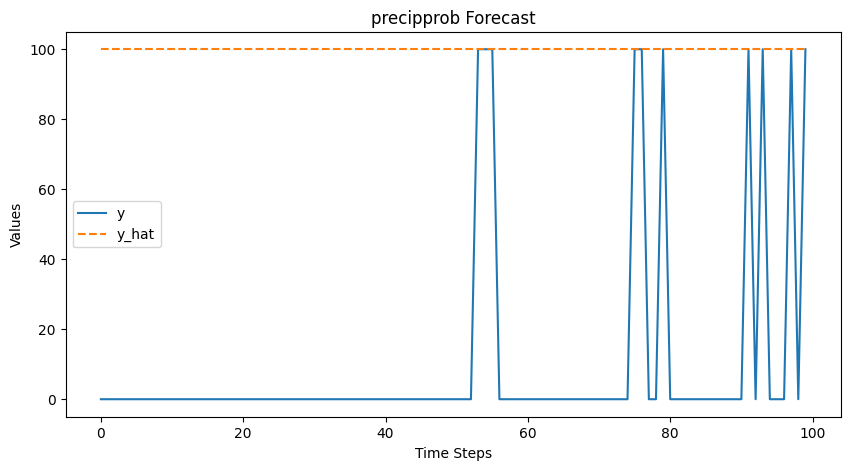

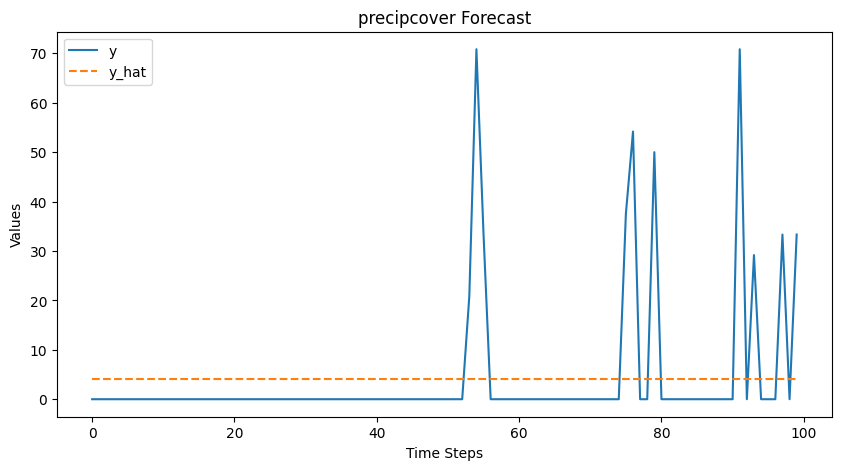

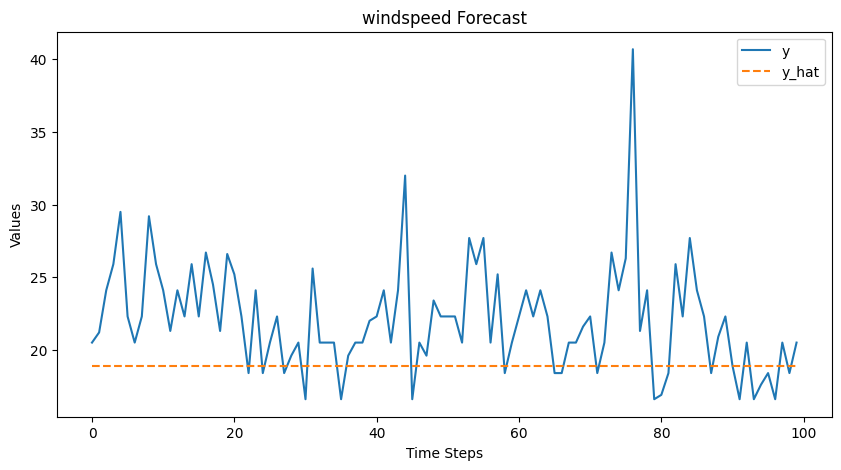

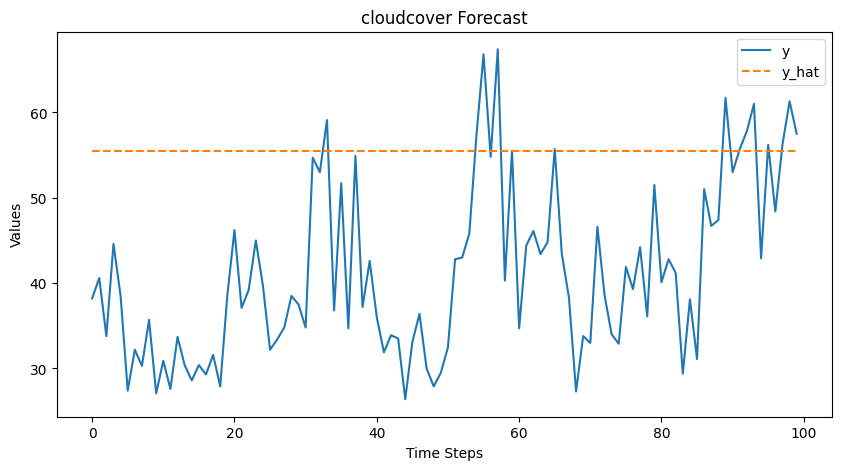

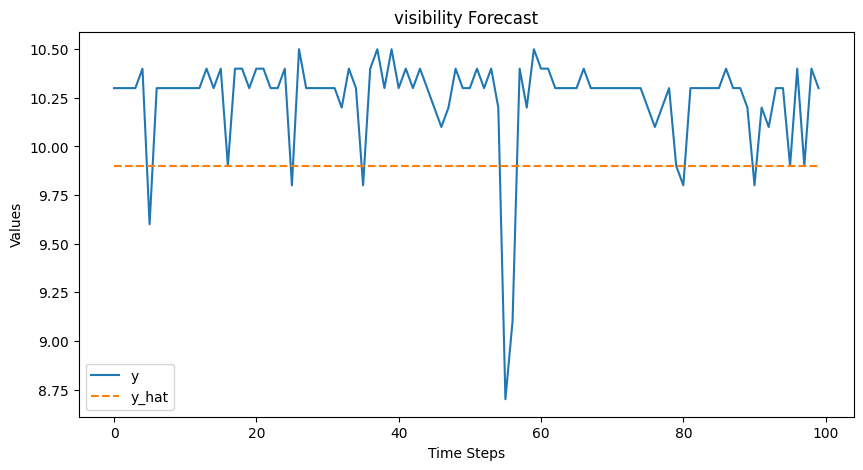

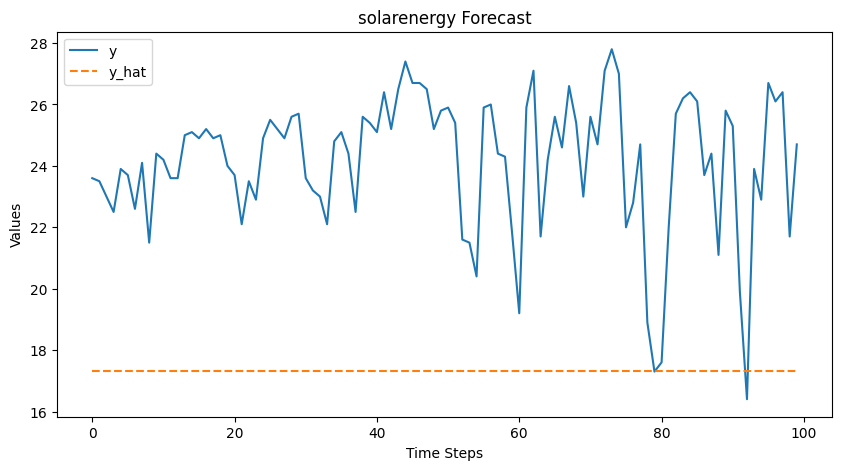

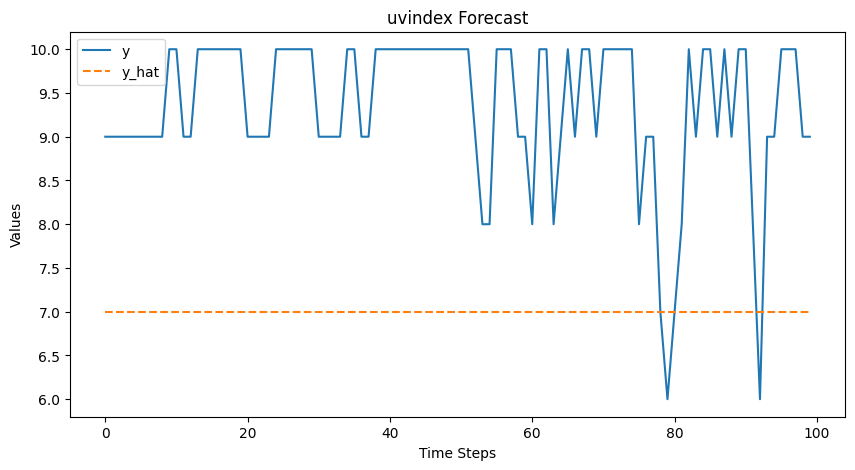

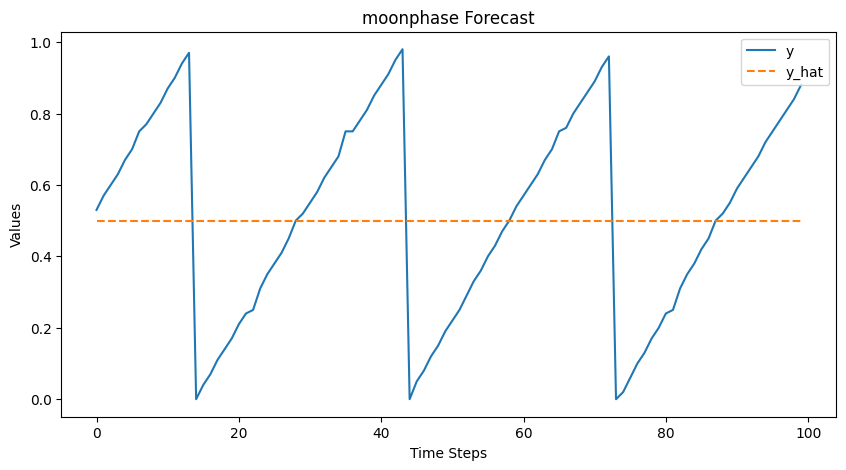

In [266]:
# Generate predictions on the training data
mul2mul_data_x = multi2multi_loader.train_loader
mul2mul_data_y = multi2multi_loader.y_train
model_activation = BiLSTM_multi2multi_manager
yhat = model_activation.predict(mul2mul_data_x)

# Get the true values
y = mul2mul_data_y

# Plot the true values against the predictions
model_activation.plot(y,yhat, feature_names=["tempmax","tempmin","temp","feelslikemax","feelslikemin","feelslike","dew","humidity","precip","precipprob","precipcover","windspeed","cloudcover","visibility","solarenergy","uvindex","moonphase"], num_elements=100, save_plots=False)

In [ ]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable, hidden_size=hidden_size, output_size=multi2uni_loader.out_variable, ahead=label_size, num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni, train_loader=multi2uni_loader.train_loader, val_loader=multi2uni_loader.val_loader, lr=learning_rate, patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs, save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader),
})
results[-1]